# Analysis for Mutual Fund Sales 

In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing steps

In [2]:
# Check current working directory
print("Current working directory:", os.getcwd())
print("Contents of current directory:", os.listdir('.'))
excel_path = os.path.join('..', 'data', 'raw', 'DataScientist_CaseStudy_Dataset.xlsx')
xls = pd.ExcelFile(excel_path)
datasets = {sheet: pd.read_excel(xls, sheet_name=sheet, engine="openpyxl") for sheet in xls.sheet_names}
print("All sheet names:", list(datasets.keys()))
print("Available datasets:", datasets.keys())
raw_datasets = datasets.pop('Description')
# check the length of each dataset
for name, df in datasets.items():
    print(f"{name}: {len(df)} rows, {len(df.columns)} columns")

Current working directory: /home/c-hiy/direct-marketing-optimization/notebooks
Contents of current directory: ['cc_analysis.ipynb', 'mf_analysis.ipynb', 'general_analysis.ipynb', 'cl_analysis.ipynb']
All sheet names: ['Description', 'Soc_Dem', 'Products_ActBalance', 'Inflow_Outflow', 'Sales_Revenues']
Available datasets: dict_keys(['Description', 'Soc_Dem', 'Products_ActBalance', 'Inflow_Outflow', 'Sales_Revenues'])
Soc_Dem: 1615 rows, 4 columns
Products_ActBalance: 1615 rows, 13 columns
Inflow_Outflow: 1587 rows, 15 columns
Sales_Revenues: 969 rows, 7 columns


In [3]:
for df in datasets.values():
    pd.set_option('display.max_columns', None)  # Show all columns
    print(df.columns.tolist())

['Client', 'Sex', 'Age', 'Tenure']
['Client', 'Count_CA', 'Count_SA', 'Count_MF', 'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL']
['Client', 'VolumeCred', 'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb', 'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA', 'TransactionsDebCash_Card', 'TransactionsDebCashless_Card', 'TransactionsDeb_PaymentOrder']
['Client', 'Sale_MF', 'Sale_CC', 'Sale_CL', 'Revenue_MF', 'Revenue_CC', 'Revenue_CL']


In [4]:
# Get clients from Sales_Revenues dataset
sales_clients = set(datasets['Sales_Revenues']['Client'].unique())
print(f"Clients in Sales_Revenues: {len(sales_clients)}")

# Create train and test datasets
datasets_train = {}
datasets_test = {}

for name, df in datasets.items():
    if 'Client' in df.columns:
        # Train: clients that exist in Sales_Revenues
        train_mask = df['Client'].isin(sales_clients)
        train_df = df[train_mask].copy()
        
        # Test: clients that do NOT exist in Sales_Revenues
        test_df = df[~train_mask].copy()
        
        # Store with new names
        datasets_train[f"{name}_train"] = train_df
        datasets_test[f"{name}_test"] = test_df
        
        print(f"{name}:")
        print(f"  Total rows: {len(df)}")
        print(f"  Train rows: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
        print(f"  Test rows: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")
        print(f"  Train unique clients: {train_df['Client'].nunique()}")
        print(f"  Test unique clients: {test_df['Client'].nunique()}")
        print()

# Summary
print("=== TRAIN DATASETS ===")
for name, df in datasets_train.items():
    print(f"{name}: {len(df)} rows, {df['Client'].nunique()} unique clients")

print("\n=== TEST DATASETS ===")
for name, df in datasets_test.items():
    print(f"{name}: {len(df)} rows, {df['Client'].nunique()} unique clients")

# Verification
print(f"\n=== VERIFICATION ===")
print(f"Sales_Revenues clients: {len(sales_clients)}")
print(f"Sales_Revenues_train clients: {datasets_train['Sales_Revenues_train']['Client'].nunique()}")
print(f"Sales_Revenues_test clients: {datasets_test['Sales_Revenues_test']['Client'].nunique()}")
print(f"Should be equal: {len(sales_clients) == datasets_train['Sales_Revenues_train']['Client'].nunique()}")
print(f"Test should be 0: {datasets_test['Sales_Revenues_test']['Client'].nunique() == 0}")

Clients in Sales_Revenues: 969
Soc_Dem:
  Total rows: 1615
  Train rows: 969 (60.0%)
  Test rows: 646 (40.0%)
  Train unique clients: 969
  Test unique clients: 646

Products_ActBalance:
  Total rows: 1615
  Train rows: 969 (60.0%)
  Test rows: 646 (40.0%)
  Train unique clients: 969
  Test unique clients: 646

Inflow_Outflow:
  Total rows: 1587
  Train rows: 951 (59.9%)
  Test rows: 636 (40.1%)
  Train unique clients: 951
  Test unique clients: 636

Sales_Revenues:
  Total rows: 969
  Train rows: 969 (100.0%)
  Test rows: 0 (0.0%)
  Train unique clients: 969
  Test unique clients: 0

=== TRAIN DATASETS ===
Soc_Dem_train: 969 rows, 969 unique clients
Products_ActBalance_train: 969 rows, 969 unique clients
Inflow_Outflow_train: 951 rows, 951 unique clients
Sales_Revenues_train: 969 rows, 969 unique clients

=== TEST DATASETS ===
Soc_Dem_test: 646 rows, 646 unique clients
Products_ActBalance_test: 646 rows, 646 unique clients
Inflow_Outflow_test: 636 rows, 636 unique clients
Sales_Revenu

In [17]:
# keep only Revenue_MF and Sale_MF
datasets_train['Sales_Revenues_train'] = datasets_train['Sales_Revenues_train'][['Client', 'Revenue_MF', 'Sale_MF']]

## Data Leakage Factors:
- `Count_MF` : number of live mutual funds
- `ActBal_MF` : actual mutual funds balance [EUR]
- `Revenue_MF` : target value
# Medium risk leakage factors that may correlate too strongly:
- `VolumeCred` : monthly credit turnover [EUR] - may reflect MF contributions
- `VolumeDeb` : monthly debit turnover [EUR] - may reflect MF withdrawals  
- `TransactionsCred` : number of all credit transactions - investment activity
- `TransactionsDeb` : number of all debit transactions - investment activity

In [19]:
def merge_all_training_data(datasets_dict, base_dataset_key='Sales_Revenues_train', 
                           datasets_to_merge=None, join_key='Client'):
    """
    Merge all training datasets on a specified key for comprehensive analysis
    
    Parameters:
    -----------
    datasets_dict : dict
        Dictionary containing all datasets to merge
    base_dataset_key : str
        Key for the base dataset (default: 'Sales_Revenues_train')
    datasets_to_merge : list, optional
        List of dataset keys to merge. If None, merges all except base
    join_key : str
        Column name to join on (default: 'Client')
    
    Returns:
    --------
    pandas.DataFrame
        Merged dataset
    """
    
    print("=== MERGING ALL TRAINING DATASETS ===")
    
    # Validate base dataset exists
    if base_dataset_key not in datasets_dict:
        raise ValueError(f"Base dataset '{base_dataset_key}' not found in datasets")
    
    # Start with base dataset
    merged_df = datasets_dict[base_dataset_key].copy()
    print(f"Base dataset ({base_dataset_key}): {merged_df.shape}")
    
    # Determine datasets to merge
    if datasets_to_merge is None:
        datasets_to_merge = [key for key in datasets_dict.keys() if key != base_dataset_key]
    
    # Validate join key exists in base dataset
    if join_key not in merged_df.columns:
        raise ValueError(f"Join key '{join_key}' not found in base dataset")
    
    # Merge each dataset
    for dataset_name in datasets_to_merge:
        if dataset_name in datasets_dict:
            df_to_merge = datasets_dict[dataset_name]
            print(f"\nMerging {dataset_name}: {df_to_merge.shape}")
            
            # Check for join key column
            if join_key in df_to_merge.columns:
                # Merge on join key
                before_shape = merged_df.shape
                merged_df = merged_df.merge(df_to_merge, on=join_key, how='left', suffixes=('', '_dup'))
                after_shape = merged_df.shape
                
                print(f"  Before merge: {before_shape}")
                print(f"  After merge: {after_shape}")
                print(f"  Records with {join_key}: {merged_df[join_key].nunique()}")
                
                # Check for duplicate columns and handle them
                duplicate_cols = [col for col in merged_df.columns if col.endswith('_dup')]
                if duplicate_cols:
                    print(f"  ⚠️  Duplicate columns found: {[col.replace('_dup', '') for col in duplicate_cols]}")
                    # Drop duplicate columns
                    merged_df = merged_df.drop(columns=duplicate_cols)
                    print(f"  ✅ Dropped duplicate columns")
                    
            else:
                print(f"  ⚠️  No '{join_key}' column found in {dataset_name}")
        else:
            print(f"  ⚠️  {dataset_name} not found in datasets")
    
    print(f"\n=== FINAL MERGED DATASET ===")
    print(f"Shape: {merged_df.shape}")
    print(f"Unique {join_key}s: {merged_df[join_key].nunique()}")
    print(f"Columns: {len(merged_df.columns)}")
    
    return merged_df


def analyze_data_quality(df, show_columns=True, max_missing_display=20):
    """
    Analyze data quality of a dataset
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Dataset to analyze
    show_columns : bool
        Whether to display all column names
    max_missing_display : int
        Maximum number of missing value columns to display
    """
    
    print(f"=== DATA QUALITY CHECK ===")
    print(f"Dataset shape: {df.shape}")
    
    # Display column names if requested
    if show_columns:
        print(f"\nColumn names:")
        for i, col in enumerate(df.columns, 1):
            print(f"{i:2d}. {col}")
    
    # Check for missing values
    print(f"\nMissing values per column:")
    missing_data = df.isnull().sum()
    missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
    
    if len(missing_data) > 0:
        print(f"Found {len(missing_data)} columns with missing values:")
        display_missing = missing_data.head(max_missing_display)
        for col, count in display_missing.items():
            percentage = (count / len(df)) * 100
            print(f"  {col}: {count} ({percentage:.1f}%)")
        
        if len(missing_data) > max_missing_display:
            print(f"  ... and {len(missing_data) - max_missing_display} more columns")
    else:
        print("No missing values found! ✅")

    # Check data types
    print(f"\nData types summary:")
    dtype_summary = df.dtypes.value_counts()
    for dtype, count in dtype_summary.items():
        print(f"  {dtype}: {count} columns")
    
    # Check for potential issues
    print(f"\nPotential issues:")
    
    # Check for duplicate rows
    duplicates = df.duplicated().sum()
    if duplicates > 0:
        print(f"  ⚠️  {duplicates} duplicate rows found")
    else:
        print(f"  ✅ No duplicate rows")
    
    # Check for constant columns
    constant_cols = []
    for col in df.columns:
        if df[col].nunique() <= 1:
            constant_cols.append(col)
    
    if constant_cols:
        print(f"  ⚠️  Constant columns (nunique ≤ 1): {constant_cols}")
    else:
        print(f"  ✅ No constant columns")


# Reusable function call with parameters
combined_train_data = merge_all_training_data(
    datasets_dict=datasets_train,
    base_dataset_key='Sales_Revenues_train',
    join_key='Client'
)

# Analyze data quality
analyze_data_quality(combined_train_data, show_columns=True)

=== MERGING ALL TRAINING DATASETS ===
Base dataset (Sales_Revenues_train): (969, 3)

Merging Soc_Dem_train: (969, 4)
  Before merge: (969, 3)
  After merge: (969, 6)
  Records with Client: 969

Merging Products_ActBalance_train: (969, 13)
  Before merge: (969, 6)
  After merge: (969, 18)
  Records with Client: 969

Merging Inflow_Outflow_train: (951, 15)
  Before merge: (969, 18)
  After merge: (969, 32)
  Records with Client: 969

=== FINAL MERGED DATASET ===
Shape: (969, 32)
Unique Clients: 969
Columns: 32
=== DATA QUALITY CHECK ===
Dataset shape: (969, 32)

Column names:
 1. Client
 2. Revenue_MF
 3. Sale_MF
 4. Sex
 5. Age
 6. Tenure
 7. Count_CA
 8. Count_SA
 9. Count_MF
10. Count_OVD
11. Count_CC
12. Count_CL
13. ActBal_CA
14. ActBal_SA
15. ActBal_MF
16. ActBal_OVD
17. ActBal_CC
18. ActBal_CL
19. VolumeCred
20. VolumeCred_CA
21. TransactionsCred
22. TransactionsCred_CA
23. VolumeDeb
24. VolumeDeb_CA
25. VolumeDebCash_Card
26. VolumeDebCashless_Card
27. VolumeDeb_PaymentOrder
28. 

In [21]:
# Fill NAs with 0 
combined_train_data.fillna(0, inplace=True)

/tmp/ipykernel_32822/1316527668.py:238: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


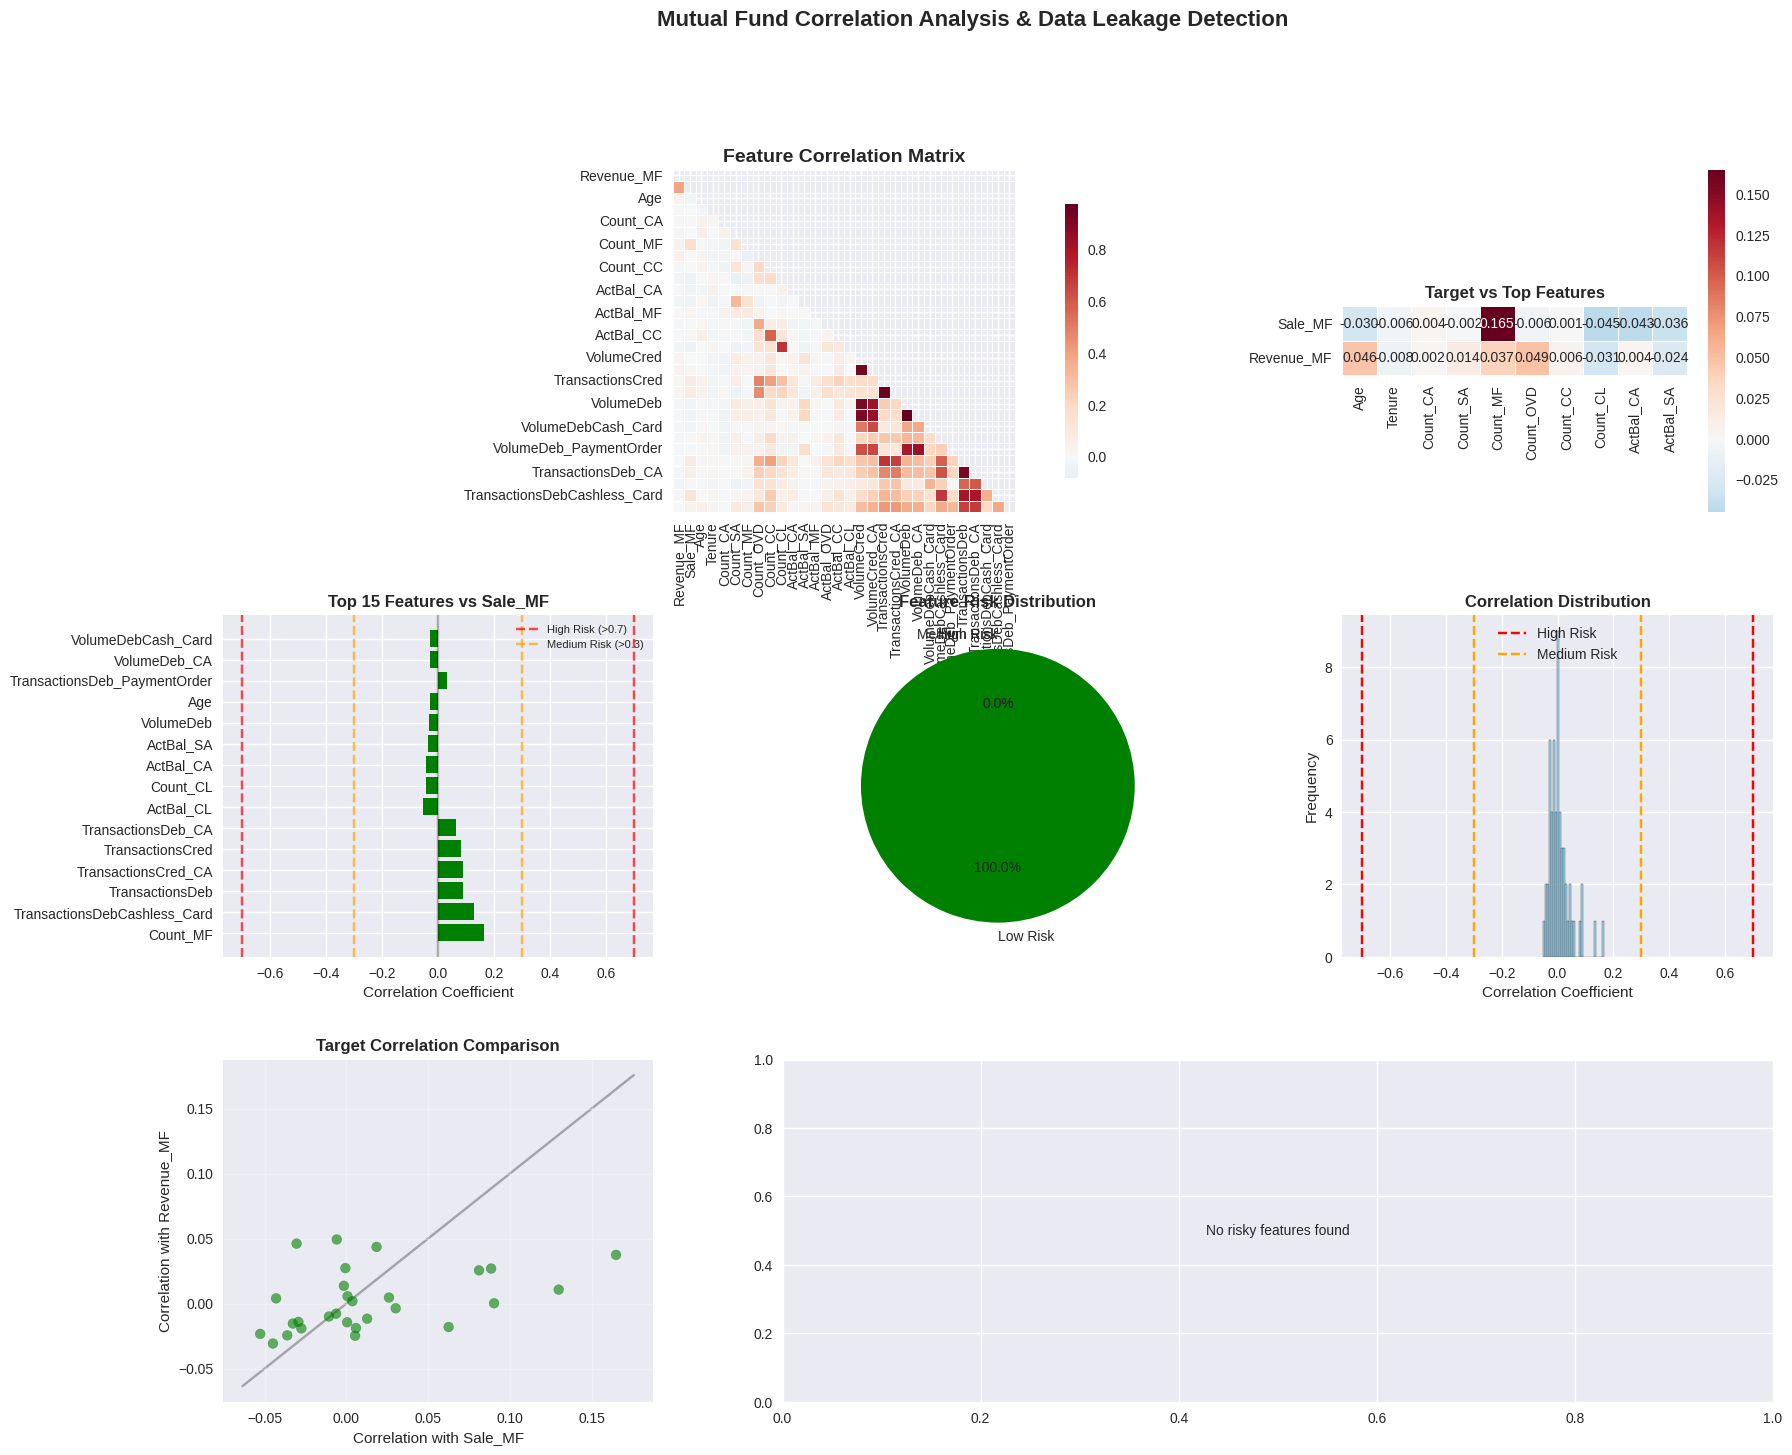

In [28]:
def calculate_correlation_matrix(df, exclude_columns=['Client']):
    """Calculate correlation matrix for numeric columns"""
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    for col in exclude_columns:
        if col in numeric_cols:
            numeric_cols.remove(col)
    return df[numeric_cols].corr()


def plot_correlation_heatmap(corr_matrix, ax, title="Correlation Matrix", mask_upper=True):
    """Plot correlation heatmap"""
    if mask_upper:
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    else:
        mask = None
    
    sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='RdBu_r', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": .8}, ax=ax)
    ax.set_title(title, fontsize=14, fontweight='bold')


def plot_target_correlation_heatmap(df, target_columns, ax, n_features=10):
    """Plot heatmap of target vs top features"""
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'Client' in numeric_cols:
        numeric_cols.remove('Client')
    
    feature_cols = [col for col in numeric_cols if col not in target_columns][:n_features]
    target_corr = df[target_columns + feature_cols].corr()
    target_subset = target_corr.loc[target_columns, feature_cols]
    
    sns.heatmap(target_subset, annot=True, cmap='RdBu_r', center=0, fmt='.3f',
                square=True, linewidths=0.5, ax=ax)
    ax.set_title('Target vs Top Features', fontsize=12, fontweight='bold')


def get_risk_colors(corr_results, target_column, high_threshold, medium_threshold):
    """Get color mapping based on correlation risk levels"""
    colors = []
    abs_corr_col = f'Abs_Corr_{target_column}'
    
    for _, row in corr_results.iterrows():
        abs_corr = row[abs_corr_col]
        if abs_corr > high_threshold:
            colors.append('red')
        elif abs_corr > medium_threshold:
            colors.append('orange')
        else:
            colors.append('green')
    return colors


def plot_correlation_barplot(corr_results, target_column, ax, n_features=15, 
                           high_threshold=0.7, medium_threshold=0.3):
    """Plot horizontal bar chart of top correlations"""
    top_corr = corr_results.head(n_features).copy()
    colors = get_risk_colors(top_corr, target_column, high_threshold, medium_threshold)
    
    bars = ax.barh(range(len(top_corr)), top_corr[f'Corr_{target_column}'], color=colors)
    ax.set_yticks(range(len(top_corr)))
    ax.set_yticklabels(top_corr['Feature'], fontsize=10)
    ax.set_xlabel('Correlation Coefficient')
    ax.set_title(f'Top {n_features} Features vs {target_column}', fontsize=12, fontweight='bold')
    
    # Add reference lines
    ax.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    ax.axvline(x=high_threshold, color='red', linestyle='--', alpha=0.7, 
               label=f'High Risk (>{high_threshold})')
    ax.axvline(x=-high_threshold, color='red', linestyle='--', alpha=0.7)
    ax.axvline(x=medium_threshold, color='orange', linestyle='--', alpha=0.7, 
               label=f'Medium Risk (>{medium_threshold})')
    ax.axvline(x=-medium_threshold, color='orange', linestyle='--', alpha=0.7)
    ax.legend(fontsize=8)


def count_risk_levels(corr_results, target_column, high_threshold, medium_threshold):
    """Count features by risk level"""
    risk_counts = {'Low Risk': 0, 'Medium Risk': 0, 'High Risk': 0}
    abs_corr_col = f'Abs_Corr_{target_column}'
    
    for _, row in corr_results.iterrows():
        abs_corr = row[abs_corr_col]
        if abs_corr > high_threshold:
            risk_counts['High Risk'] += 1
        elif abs_corr > medium_threshold:
            risk_counts['Medium Risk'] += 1
        else:
            risk_counts['Low Risk'] += 1
    return risk_counts


def plot_risk_pie_chart(corr_results, target_column, ax, high_threshold=0.7, medium_threshold=0.3):
    """Plot pie chart of feature risk distribution"""
    risk_counts = count_risk_levels(corr_results, target_column, high_threshold, medium_threshold)
    colors_pie = ['green', 'orange', 'red']
    
    wedges, texts, autotexts = ax.pie(risk_counts.values(), labels=risk_counts.keys(), 
                                     colors=colors_pie, autopct='%1.1f%%', startangle=90)
    ax.set_title('Feature Risk Distribution', fontsize=12, fontweight='bold')


def plot_correlation_histogram(corr_results, target_columns, ax, high_threshold=0.7, medium_threshold=0.3):
    """Plot histogram of correlation distribution"""
    all_corr_values = []
    for target in target_columns:
        corr_col = f'Corr_{target}'
        if corr_col in corr_results.columns:
            all_corr_values.extend(corr_results[corr_col].dropna().values)
    
    ax.hist(all_corr_values, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    ax.axvline(x=high_threshold, color='red', linestyle='--', label=f'High Risk')
    ax.axvline(x=-high_threshold, color='red', linestyle='--')
    ax.axvline(x=medium_threshold, color='orange', linestyle='--', label=f'Medium Risk')
    ax.axvline(x=-medium_threshold, color='orange', linestyle='--')
    ax.set_xlabel('Correlation Coefficient')
    ax.set_ylabel('Frequency')
    ax.set_title('Correlation Distribution', fontsize=12, fontweight='bold')
    ax.legend()


def plot_target_correlation_scatter(corr_results, target_columns, ax, high_threshold=0.7, medium_threshold=0.3):
    """Plot scatter plot comparing correlations between targets"""
    if len(target_columns) < 2:
        ax.text(0.5, 0.5, 'Need at least 2 targets', ha='center', va='center', transform=ax.transAxes)
        return
    
    corr_col1 = f'Corr_{target_columns[0]}'
    corr_col2 = f'Corr_{target_columns[1]}'
    
    if corr_col1 not in corr_results.columns or corr_col2 not in corr_results.columns:
        ax.text(0.5, 0.5, 'Missing correlation columns', ha='center', va='center', transform=ax.transAxes)
        return
    
    scatter_colors = get_risk_colors(corr_results, target_columns[0], high_threshold, medium_threshold)
    
    ax.scatter(corr_results[corr_col1], corr_results[corr_col2], 
               c=scatter_colors, alpha=0.6, s=50)
    ax.set_xlabel(f'Correlation with {target_columns[0]}')
    ax.set_ylabel(f'Correlation with {target_columns[1]}')
    ax.set_title('Target Correlation Comparison', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add diagonal line
    lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]),
           max(ax.get_xlim()[1], ax.get_ylim()[1])]
    ax.plot(lims, lims, 'k-', alpha=0.3, zorder=0)


def plot_risky_features_detail(corr_results, target_column, ax, high_threshold=0.7, medium_threshold=0.3):
    """Plot detailed view of high and medium risk features"""
    abs_corr_col = f'Abs_Corr_{target_column}'
    
    high_risk = corr_results[corr_results[abs_corr_col] > high_threshold]
    medium_risk = corr_results[
        (corr_results[abs_corr_col] > medium_threshold) & 
        (corr_results[abs_corr_col] <= high_threshold)
    ]
    
    risky_features = pd.concat([high_risk, medium_risk.head(10-len(high_risk))])
    
    if len(risky_features) == 0:
        ax.text(0.5, 0.5, 'No risky features found', ha='center', va='center', transform=ax.transAxes)
        return
    
    y_pos = np.arange(len(risky_features))
    corr_values = risky_features[f'Corr_{target_column}'].values
    
    bar_colors = ['red' if abs(corr) > high_threshold else 'orange' for corr in corr_values]
    
    bars = ax.barh(y_pos, corr_values, color=bar_colors, alpha=0.7)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(risky_features['Feature'], fontsize=10)
    ax.set_xlabel('Correlation Coefficient')
    ax.set_title('High & Medium Risk Features Detail', fontsize=12, fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    ax.grid(True, axis='x', alpha=0.3)
    
    # Add value labels
    for i, val in enumerate(corr_values):
        ax.text(val + 0.01 if val > 0 else val - 0.01, i, f'{val:.3f}', 
                va='center', ha='left' if val > 0 else 'right', fontsize=9)


def plot_correlation_analysis(df, corr_results, target_columns=['Sale_MF', 'Revenue_MF'],
                             high_corr_threshold=0.7, medium_corr_threshold=0.3,
                             figsize=(20, 16)):
    """
    Generate comprehensive correlation visualizations using atomic functions
    """
    plt.style.use('seaborn-v0_8')
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # Calculate correlation matrix once
    corr_matrix = calculate_correlation_matrix(df)
    primary_target = target_columns[0]
    
    # 1. Full correlation heatmap
    ax1 = fig.add_subplot(gs[0, :2])
    plot_correlation_heatmap(corr_matrix, ax1, "Feature Correlation Matrix")
    
    # 2. Target correlation heatmap
    ax2 = fig.add_subplot(gs[0, 2])
    plot_target_correlation_heatmap(df, target_columns, ax2)
    
    # 3. Top correlations bar plot
    ax3 = fig.add_subplot(gs[1, 0])
    plot_correlation_barplot(corr_results, primary_target, ax3, 
                           high_threshold=high_corr_threshold, 
                           medium_threshold=medium_corr_threshold)
    
    # 4. Risk level pie chart
    ax4 = fig.add_subplot(gs[1, 1])
    plot_risk_pie_chart(corr_results, primary_target, ax4,
                       high_threshold=high_corr_threshold,
                       medium_threshold=medium_corr_threshold)
    
    # 5. Correlation distribution histogram
    ax5 = fig.add_subplot(gs[1, 2])
    plot_correlation_histogram(corr_results, target_columns, ax5,
                              high_threshold=high_corr_threshold,
                              medium_threshold=medium_corr_threshold)
    
    # 6. Target correlation scatter
    ax6 = fig.add_subplot(gs[2, 0])
    plot_target_correlation_scatter(corr_results, target_columns, ax6,
                                   high_threshold=high_corr_threshold,
                                   medium_threshold=medium_corr_threshold)
    
    # 7. Risky features detail
    ax7 = fig.add_subplot(gs[2, 1:])
    plot_risky_features_detail(corr_results, primary_target, ax7,
                              high_threshold=high_corr_threshold,
                              medium_threshold=medium_corr_threshold)
    
    plt.suptitle('Mutual Fund Correlation Analysis & Data Leakage Detection', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()


# Generate the plots
plot_correlation_analysis(
    df=combined_train_data,
    corr_results=corr_results_pearson,
    target_columns=['Sale_MF', 'Revenue_MF'],
    high_corr_threshold=0.7,
    medium_corr_threshold=0.3,
    figsize=(20, 16)
)